In [1]:
from warnings import filterwarnings
from json import dump
from math import log10, floor, ceil

import matplotlib.pyplot as plt
from optuna import load_study
from optuna.exceptions import ExperimentalWarning

# from optuna.visualization import plot_pareto_front, plot_slice
from optuna.visualization.matplotlib import plot_pareto_front, plot_slice
from pandas import DataFrame, set_option

filterwarnings("ignore", category=ExperimentalWarning)

In [2]:
def get_study(study_name, folder="."):
    db_name = f"{folder}/{study_name}.db"
    storage_name = f"sqlite:///{db_name}"
    study = load_study(study_name=study_name, storage=storage_name)
    print(study.study_name, "loaded.")
    return study

In [3]:
study_1 = get_study("HP-optimization-01", folder="hp1")
study_2 = get_study("HP-optimization-02", folder="hp2")

HP-optimization-01 loaded.
HP-optimization-02 loaded.


In [7]:
{trial.state for trial in study_1.trials}

{TrialState.COMPLETE, TrialState.PRUNED}

# Influence of the HPs

In [29]:
min_mse_scale, max_mse_scale = 1e-4, 1e2

(0.0001, 100.0)

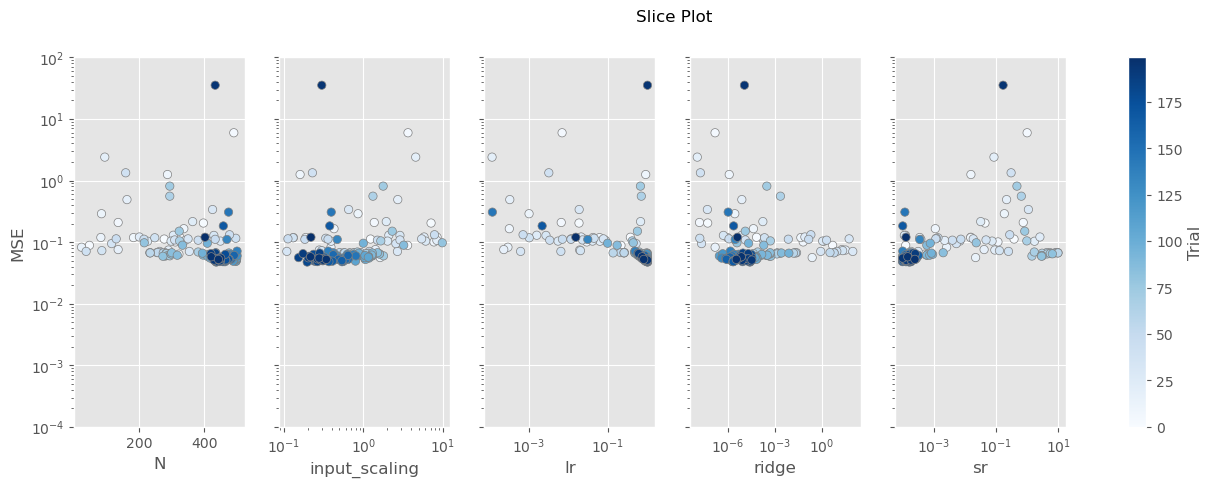

In [30]:
axes = plot_slice(
    study_1,
    params=["N", "sr", "lr", "ridge", "input_scaling"],
    target=lambda t: t.values[0],
    target_name="MSE",
)
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim(bottom=min_mse_scale, top=max_mse_scale)

(0.0001, 100.0)

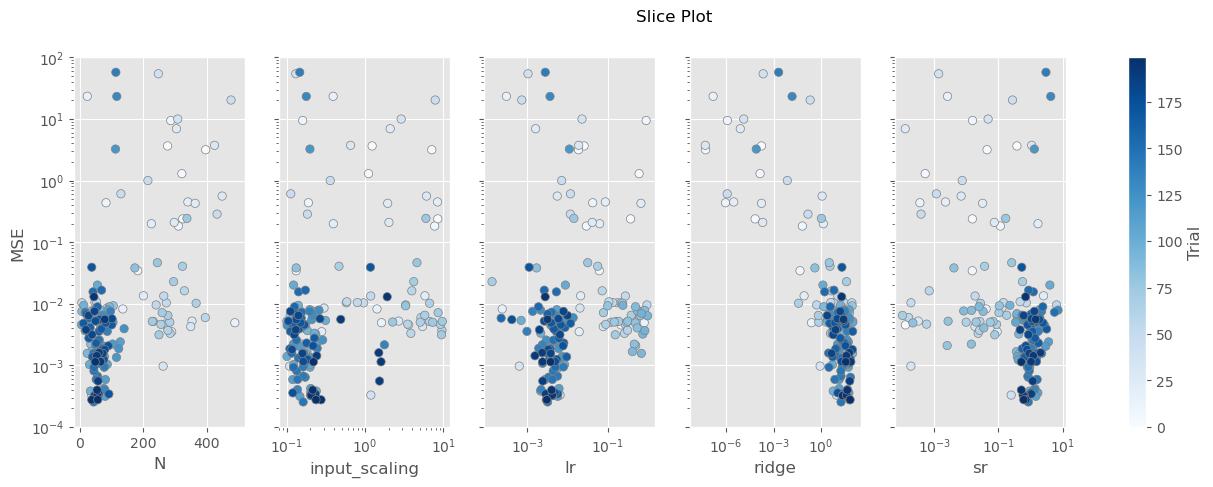

In [31]:
axes = plot_slice(
    study_2,
    params=["N", "sr", "lr", "ridge", "input_scaling"],
    target=lambda t: t.values[0],
    target_name="MSE",
)
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim(bottom=min_mse_scale, top=max_mse_scale)

# Best trials (Pareto front)

In [9]:
ax = plot_pareto_front(study_1, target_names=["MSE", "N"])

ax.set_xlim(left=min_mse_scale, right=max_mse_scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Pareto-front for optimization #1")

ValueError: `plot_pareto_front` function only supports 2 or 3 objective studies when using `targets` is `None`. Please use `targets` if your objective studies have more than 3 objectives.

In [10]:
study = study_1
DataFrame(
    [
        {"trial_num": t.number, "MSE": t.values[0], "N": int(t.values[1])}
        for t in study.best_trials
    ]
).set_index("trial_num").sort_values("MSE")

IndexError: list index out of range

In [9]:
best_params_1 = [
    study_1.trials[26].params,
]

Text(0.5, 1.0, 'Pareto-front for optimization #2')

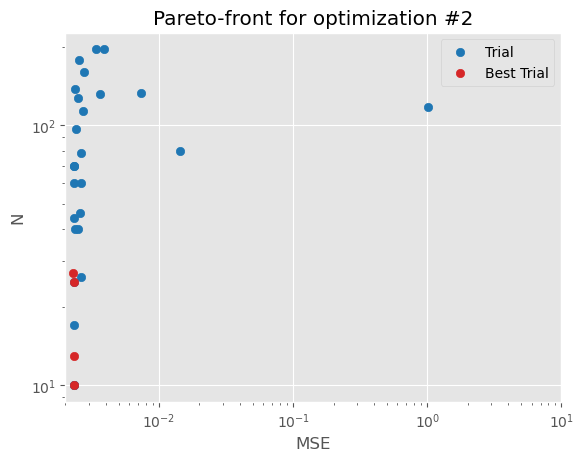

In [10]:
ax = plot_pareto_front(study_2, target_names=["MSE", "N"])

ax.set_xlim(left=min_mse_scale, right=max_mse_scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Pareto-front for optimization #2")

In [11]:
study = study_2
DataFrame(
    [
        {"trial_num": t.number, "MSE": t.values[0], "N": int(t.values[1])}
        for t in study.best_trials
    ]
).set_index("trial_num").sort_values("MSE")

,MSE,N
trial_num,,
25,0.002294,27
27,0.002302,25
20,0.002302,13
23,0.002304,10


In [12]:
best_params_2 = [
    study_2.trials[23].params,
]

Comparison between the best params of both optimizations.

In [13]:
set_option("display.float_format", "{:#.2g}".format)
df_best = DataFrame(best_params_1 + best_params_2)
df_best

,N,sr,lr,input_scaling,ridge
0,10,7.9,0.0022,0.33,27.
1,10,7.4,0.0021,0.29,83.


In [14]:
dict_params = df_best.median().to_dict()
dict_params

{'N': 10.0,
 'sr': 7.629485668647677,
 'lr': 0.002159994810220037,
 'input_scaling': 0.3084711679060537,
 'ridge': 55.068274395436774}

In [15]:
dict_params["N"] = int(dict_params["N"])

In [16]:
with open("HP_medians.json", "w") as j:
    dump(dict_params, j)